<a href="https://colab.research.google.com/github/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/01_intro_DLDIY_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CNN for dogs vs cats

We are going to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) competition at Kaggle.

There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if you can beat 80%, then you will be at the cutting edge as of 2013!

##  Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

In [2]:
torch.__version__

'1.0.0'

In [3]:
import sys
sys.version

'3.6.7 (default, Oct 21 2018, 08:08:16) \n[GCC 8.2.0]'

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Downloading the data

You can download the full dataset from Kaggle directly.

Alternatively, Jeremy Howard provides a direct link to the catvsdogs [dataset](http://files.fast.ai/data/dogscats.zip). He's separated the cats and dogs into separate folders and created a validation folder as well. You'll need this folder structure to run VGG.

For test purpose (or if you run on cpu), you should use the (small) sample directory.

In [0]:
%mkdir data
%cd /content/data/
!wget http://files.fast.ai/data/dogscats.zip

In [0]:
!unzip dogscats.zip

In [0]:
%ls

In [0]:
%cd dogscats/
%ls

## Data processing

In [0]:
%cd ..

In [5]:
data_dir = '/home/public/dogscats'#'/content/data/dogscats'

```datasets``` is a class of the ```torchvision``` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network.

Images needs a bit of preparation before passing them throught the network. They need to have all the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [7]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['train', 'valid']}

In [8]:
os.path.join(data_dir,'train')

'/home/public/dogscats/train'

Interactive help on jupyter notebook thanks to `?`

In [0]:
?datasets.ImageFolder

We see that `datasets.ImageFolder` has attributes: classes, class_to_idx, imgs.

Let see what they are?

In [9]:
dsets['train'].classes

['cats', 'dogs']

In [10]:
dsets['train'].class_to_idx

{'cats': 0, 'dogs': 1}

In [11]:
dsets['train'].imgs[:5]

[('/home/public/dogscats/train/cats/cat.0.jpg', 0),
 ('/home/public/dogscats/train/cats/cat.1.jpg', 0),
 ('/home/public/dogscats/train/cats/cat.10.jpg', 0),
 ('/home/public/dogscats/train/cats/cat.100.jpg', 0),
 ('/home/public/dogscats/train/cats/cat.1000.jpg', 0)]

In [12]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_sizes

{'train': 23000, 'valid': 2000}

In [13]:
dset_classes = dsets['train'].classes

The ```torchvision``` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the ```torchvision.transforms.Compose``` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

The magic help `?` allows you to retrieve function you defined and forgot!

In [0]:
?vgg_format

In [14]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)

In [0]:
?torch.utils.data.DataLoader

In [227]:
loader_valid = torch.utils.data.DataLoader(dsets['valid'], batch_size=128, shuffle=False, num_workers=6)

In [16]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count +=1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [17]:
labels_try

tensor([0, 0, 1, 1, 1])

In [18]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

A small function to display images:

In [19]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

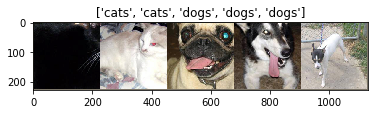

In [20]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

What is an image for your computer?

In [21]:
inputs_try

tensor([[[[-1.8610, -1.7583, -1.6898,  ..., -1.3473, -1.3987, -1.2959],
          [-1.9295, -1.8610, -1.7925,  ..., -1.4843, -1.4500, -1.3302],
          [-1.9809, -1.9638, -1.8782,  ..., -1.4158, -1.4500, -1.3644],
          ...,
          [-2.0323, -2.0323, -1.9809,  ..., -1.7925, -1.9809, -1.8610],
          [-1.9980, -1.9809, -1.9467,  ..., -1.7754, -1.9638, -1.8782],
          [-1.9809, -1.9638, -1.9467,  ..., -1.9467, -1.9295, -1.8953]],

         [[-1.7381, -1.6331, -1.5280,  ..., -1.5105, -1.5105, -1.4230],
          [-1.8081, -1.7381, -1.6331,  ..., -1.6856, -1.6155, -1.4930],
          [-1.8606, -1.8431, -1.7206,  ..., -1.6155, -1.6506, -1.5280],
          ...,
          [-1.9482, -1.9482, -1.8957,  ..., -1.7031, -1.8957, -1.7731],
          [-1.9132, -1.8957, -1.8606,  ..., -1.7031, -1.8957, -1.7906],
          [-1.8957, -1.8782, -1.8606,  ..., -1.8431, -1.8256, -1.7906]],

         [[-1.5256, -1.4210, -1.3164,  ..., -1.1944, -1.2119, -1.0724],
          [-1.5953, -1.5256, -

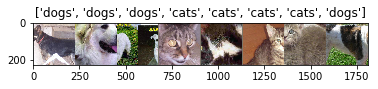

In [23]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

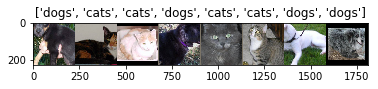

In [44]:
# Get a batch of validation data
inputs, classes = next(iter(loader_valid))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## Creating VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if ```pretrained=True``` the model is fetched over the internet and downloaded to ```~/.torch/models```.
For next calls, the model will be directly read from there.

In [100]:
model_vgg = models.vgg16(pretrained=True)

We will first use VGG Model without any modification. In order to interpret the results, we need to import the 1000 ImageNet categories, available at: [https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json](https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json)

In [0]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [0]:
import json

fpath = '/content/data/imagenet_class_index.json'

with open(fpath) as f:
    class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [0]:
dic_imagenet[:4]

In [26]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [27]:
outputs_try = model_vgg(inputs_try)

In [28]:
outputs_try

tensor([[ -0.6435,  -2.1874,  -0.1957,  ...,  -2.5722,   1.5765,   1.2478],
        [ -0.4355,  -4.2574,   3.7013,  ...,  -2.4806,  -0.6295,   2.8973],
        [  1.0670,  -7.3371,  -6.0806,  ..., -11.5063,   3.5496,   5.4137],
        [ -3.8047,  -6.3978,  -0.2117,  ...,  -3.4002,   1.9327,   3.9016],
        [ -0.6846,  -3.7000,   0.7728,  ...,  -5.8661,   0.3118,   3.2418]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [29]:
outputs_try.shape

torch.Size([5, 1000])

To translate the outputs of the network into 'probabilities', we pass it through a [Softmax function](https://en.wikipedia.org/wiki/Softmax_function)

In [32]:
m_softm = nn.Softmax(dim=1)
probs = m_softm(outputs_try)
vals_try,preds_try = torch.max(probs,dim=1)

In [33]:
torch.sum(probs,1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward2>)

In [34]:
vals_try

tensor([0.1351, 0.4787, 1.0000, 0.5190, 0.9093], device='cuda:0',
       grad_fn=<MaxBackward0>)

In [0]:
print([dic_imagenet[i] for i in preds_try.data])

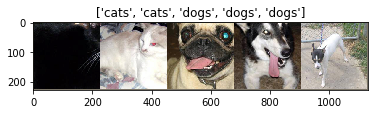

In [35]:
out = torchvision.utils.make_grid(inputs_try.data.cpu())

imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

### Modifying the last layer and setting the gradient false to all layers

In [36]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](https://mlelarge.github.io/dataflowr/Notebooks/vgg16.png)

In this practical example, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 2 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 2 class layer will be updated.

In [101]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [38]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=2, bias=True)
  (7): LogSoftmax()
)


In [102]:
model_vgg = model_vgg.to(device)

## Training fully connected module

### Creating loss function and optimizer

PyTorch documentation for [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) and the [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [103]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Training the model

In [104]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        i = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            #inputs , classes = torch.from_numpy(inputs).to(device), torch.from_numpy(classes).to(device)
            inputs = inputs.to(device)
            classes = classes.to(device)
            #inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            

            optimizer = optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
            #predictions[i:i+len(classes)] = preds.cpu()
            #all_classes[i:i+len(classes)] = classes.cpu()
            #print(preds.cpu())
            i += len(classes)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [105]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['train'],epochs=10,optimizer=optimizer_vgg)

Loss: 0.0024 Acc: 0.9495
Loss: 0.0013 Acc: 0.9719
Loss: 0.0012 Acc: 0.9737
Loss: 0.0011 Acc: 0.9743
Loss: 0.0010 Acc: 0.9753
Loss: 0.0010 Acc: 0.9760
Loss: 0.0010 Acc: 0.9752
Loss: 0.0010 Acc: 0.9763
Loss: 0.0009 Acc: 0.9764
Loss: 0.0009 Acc: 0.9770
CPU times: user 4min 43s, sys: 2min 39s, total: 7min 22s
Wall time: 7min 28s


In [106]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,2))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for inputs,classes in dataloader:
        
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        #print(i)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
            #print(preds.cpu())
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [107]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['valid'])

Loss: 0.0003 Acc: 0.9865


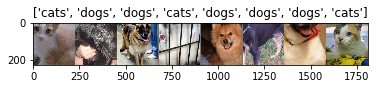

In [108]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [109]:
#inputs = torch.from_numpy(conv_feat_val[:n_images])
#inputs = inputs.view(inputs.size(0), -1)
outputs = model_vgg(inputs[:n_images].to(device))
print(torch.exp(outputs))

tensor([[9.9153e-01, 8.4649e-03],
        [4.6323e-02, 9.5368e-01],
        [6.8861e-04, 9.9931e-01],
        [9.9682e-01, 3.1772e-03],
        [7.1089e-02, 9.2891e-01],
        [1.0351e-03, 9.9896e-01],
        [2.9119e-03, 9.9709e-01],
        [9.9962e-01, 3.7538e-04]], device='cuda:0', grad_fn=<ExpBackward>)


In [110]:
classes[:n_images]

tensor([0, 1, 1, 0, 1, 1, 1, 0])

## Speeding up the learning by precomputing features

In [124]:
x_try = model_vgg.features(inputs_try)

In [126]:
x_try.shape

torch.Size([5, 512, 7, 7])

In [130]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [131]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 27.3 s, sys: 16.5 s, total: 43.8 s
Wall time: 44.4 s


In [170]:
conv_feat_train.shape

(23000, 512, 7, 7)

In [228]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 2.09 s, sys: 1.65 s, total: 3.74 s
Wall time: 4.5 s


## Creating a new data generator

We will not load images anymore, so we need to build our own data loader.

In [133]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [191]:
def train_model(model,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        dataloader = data_gen(conv_feat_train,labels_train)
        running_loss = 0.0
        running_corrects = int(0)
        for inputs,classes in dataloader:
            inputs , classes = torch.from_numpy(inputs).to(device), torch.from_numpy(classes).to(device)
            inputs = inputs.to(device)
            classes = classes.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)

            optimizer = optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [193]:
%%time
train_model(model_vgg.classifier,size=dset_sizes['train'],epochs=50,optimizer=optimizer_vgg)

Loss: 0.0008 Acc: 0.9793
Loss: 0.0008 Acc: 0.9798
Loss: 0.0008 Acc: 0.9792
Loss: 0.0008 Acc: 0.9797
Loss: 0.0008 Acc: 0.9813
Loss: 0.0008 Acc: 0.9807
Loss: 0.0008 Acc: 0.9805
Loss: 0.0008 Acc: 0.9803
Loss: 0.0008 Acc: 0.9796
Loss: 0.0008 Acc: 0.9802
Loss: 0.0008 Acc: 0.9797
Loss: 0.0008 Acc: 0.9792
Loss: 0.0008 Acc: 0.9806
Loss: 0.0008 Acc: 0.9804
Loss: 0.0008 Acc: 0.9805
Loss: 0.0008 Acc: 0.9807
Loss: 0.0008 Acc: 0.9807
Loss: 0.0008 Acc: 0.9806
Loss: 0.0008 Acc: 0.9802
Loss: 0.0008 Acc: 0.9803
Loss: 0.0007 Acc: 0.9812
Loss: 0.0008 Acc: 0.9808
Loss: 0.0008 Acc: 0.9812
Loss: 0.0008 Acc: 0.9817
Loss: 0.0008 Acc: 0.9807
Loss: 0.0008 Acc: 0.9813
Loss: 0.0007 Acc: 0.9820
Loss: 0.0008 Acc: 0.9813
Loss: 0.0008 Acc: 0.9810
Loss: 0.0007 Acc: 0.9816
Loss: 0.0008 Acc: 0.9805
Loss: 0.0007 Acc: 0.9808
Loss: 0.0007 Acc: 0.9813
Loss: 0.0007 Acc: 0.9818
Loss: 0.0008 Acc: 0.9809
Loss: 0.0007 Acc: 0.9811
Loss: 0.0007 Acc: 0.9813
Loss: 0.0008 Acc: 0.9804
Loss: 0.0007 Acc: 0.9812
Loss: 0.0007 Acc: 0.9812


In [229]:
def test_model(model,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,2))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for inputs,classes in data_gen(conv_feat_valid,labels_valid,shuffle=False):
        inputs , classes = torch.from_numpy(inputs).to(device), torch.from_numpy(classes).to(device)
        inputs = inputs.to(device)
        classes = classes.to(device)
        inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        #print(i)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
            #print(preds.cpu())
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [230]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,size=dset_sizes['valid'])

Loss: 0.0005 Acc: 0.9860


## 4. Viewing model prediction (qualitative analysis)

The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.

With our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques after the 2 weeks break...)


As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

   1. A few correct labels at random
   2. A few incorrect labels at random
   3. The most correct labels of each class (ie those with highest probability that are correct)
   4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
   5. The most uncertain labels (ie those with probability closest to 0.5).

In general, these are particularly useful for debugging problems in the model. Since our model is very simple, there may not be too much to learn at this stage...

In [231]:
# Number of images to view for each visualization task
n_view = 8

In [232]:
correct = np.where(predictions==all_classes)[0]

In [233]:
len(correct)/dset_sizes['valid']

0.986

In [234]:
from numpy.random import random, permutation
idx = permutation(correct)[:n_view]

In [235]:
idx

array([ 311,  277, 1839,  396,   43,  212, 1048, 1954])

In [236]:
#dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format) for x in ['train', 'valid']}

loader_correct = torch.utils.data.DataLoader([dsets['valid'][x] for x in idx],batch_size = n_view,shuffle=True)

In [237]:
for data in loader_correct:
    inputs_cor,labels_cor = data

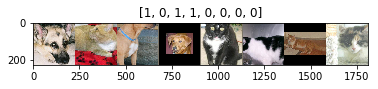

In [238]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_cor)

imshow(out, title=[l.item() for l in labels_cor])

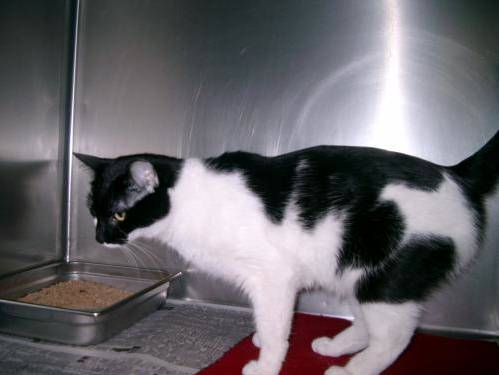

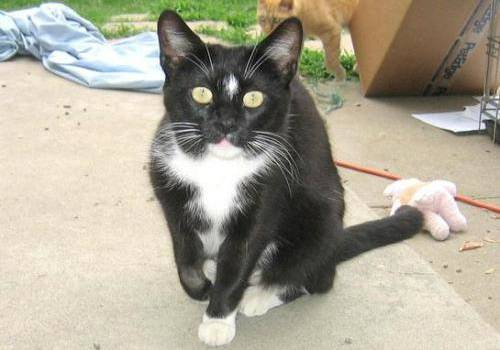

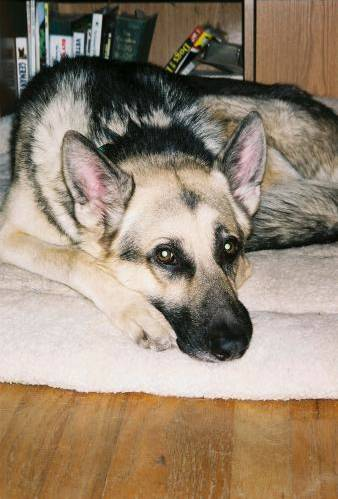

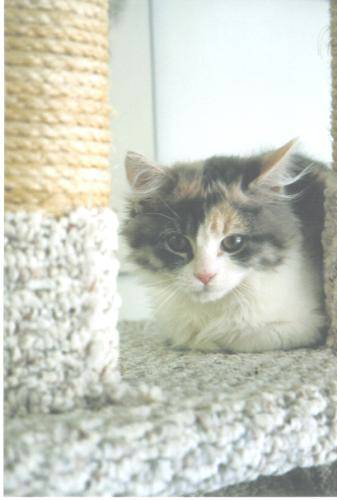

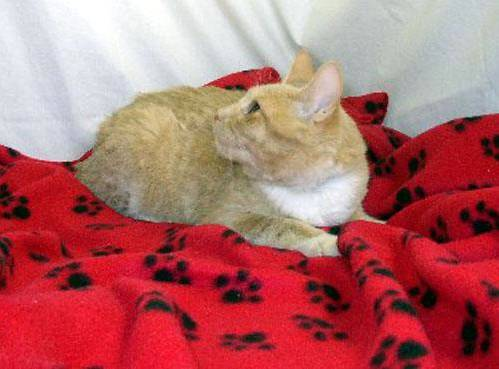

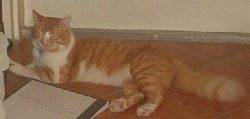

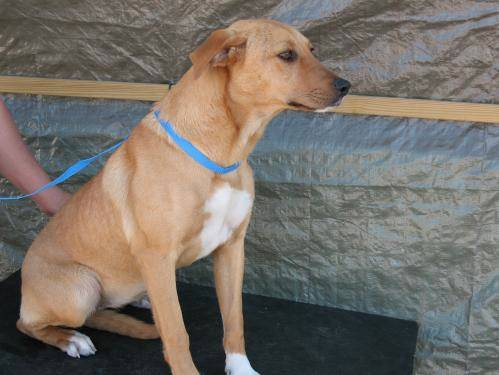

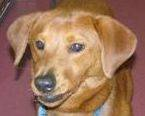

In [239]:
from IPython.display import Image, display
for x in idx:
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

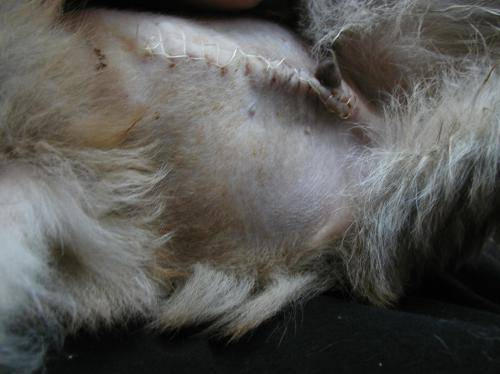

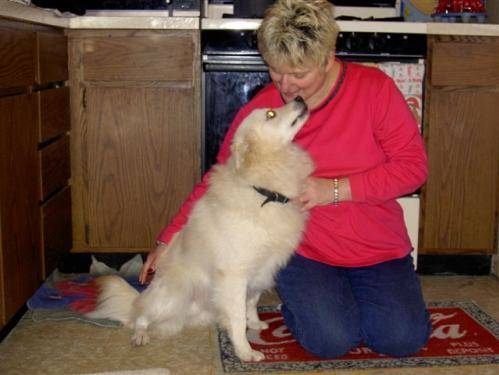

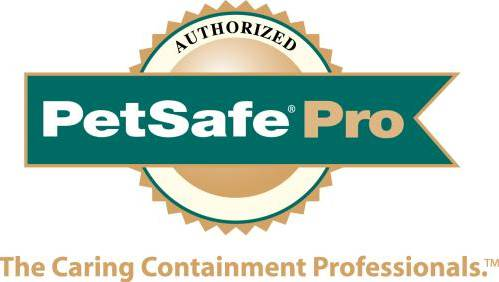

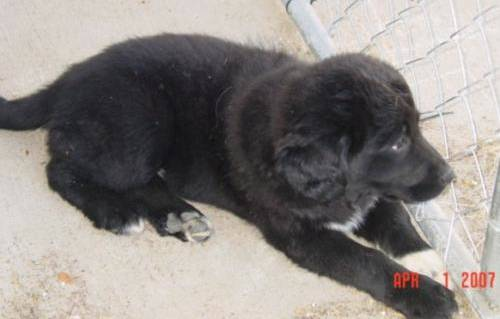

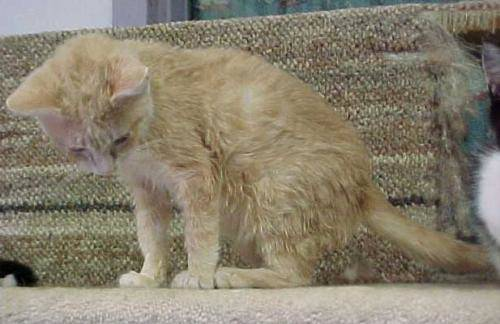

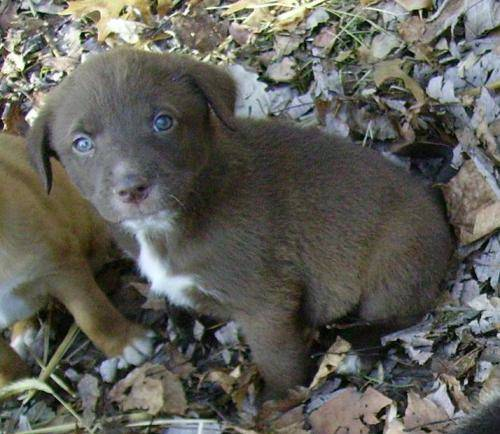

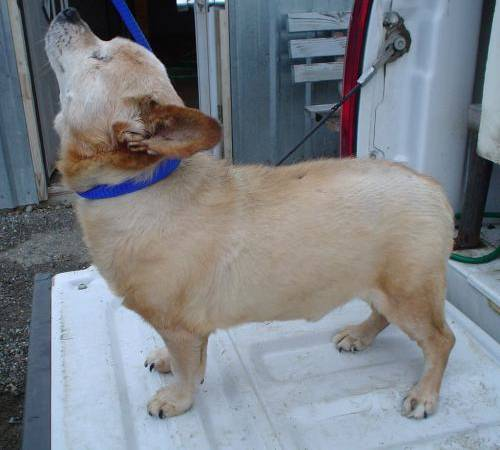

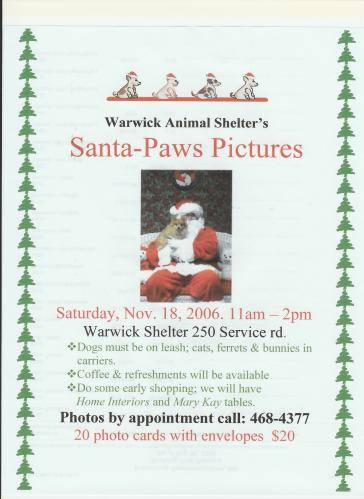

In [251]:
incorrect = np.where(predictions!=all_classes)[0]
for x in permutation(incorrect)[:n_view]:
    #print(dsets['valid'].imgs[x][1])
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

In [242]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((predictions==0) & (predictions==all_classes))[0]
most_correct_cats = np.argsort(all_proba[correct_cats,1])[:n_view]

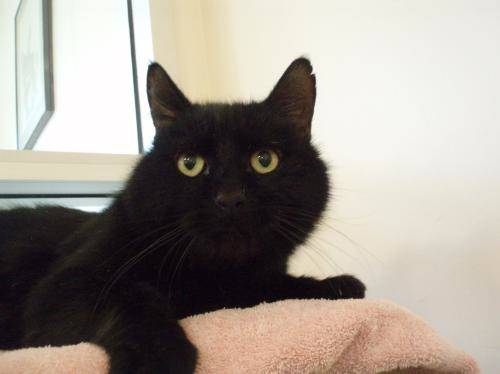

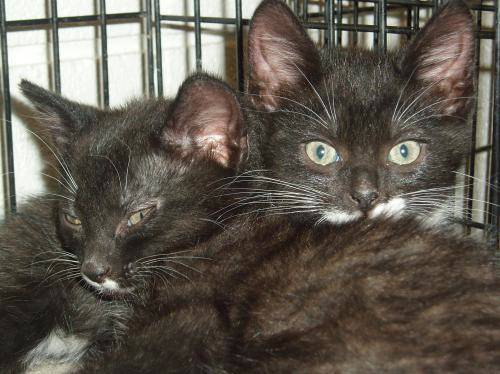

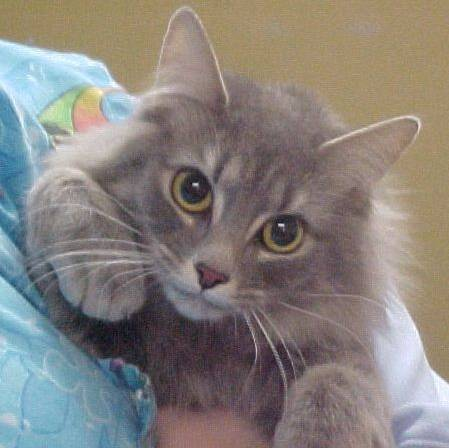

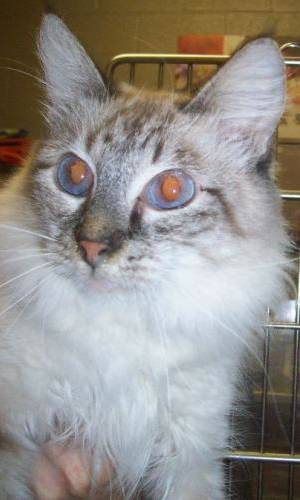

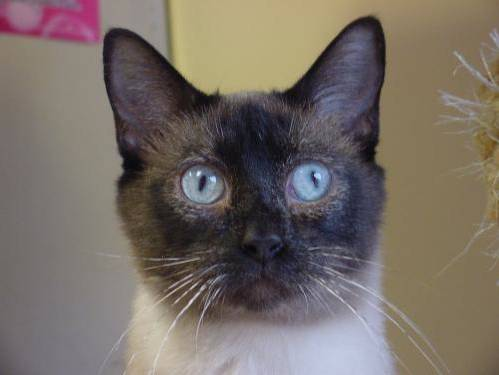

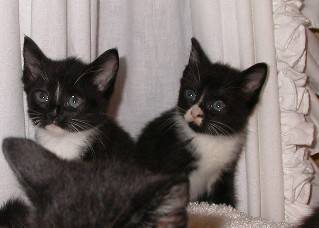

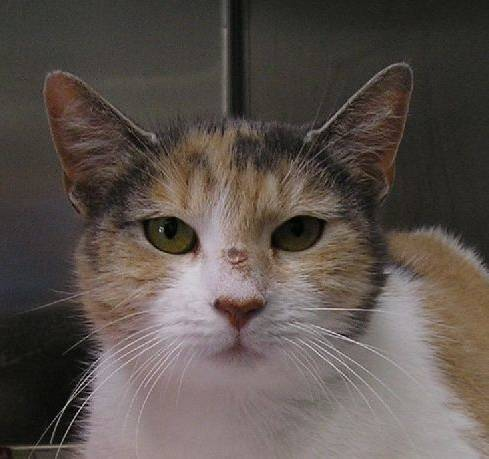

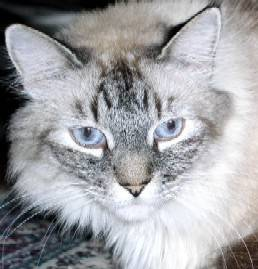

In [243]:
for x in most_correct_cats:
    display(Image(filename=dsets['valid'].imgs[correct_cats[x]][0], retina=True))

In [246]:
#3. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((predictions==1) & (predictions==all_classes))[0]
most_correct_dogs = np.argsort(all_proba[correct_dogs,0])[:n_view]

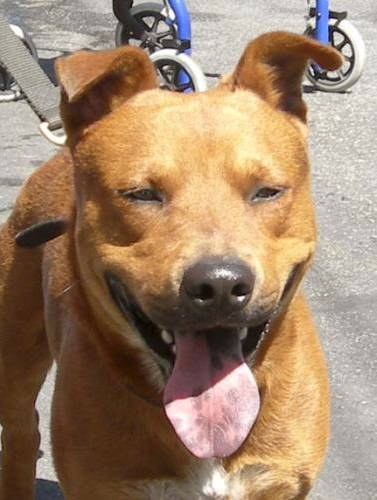

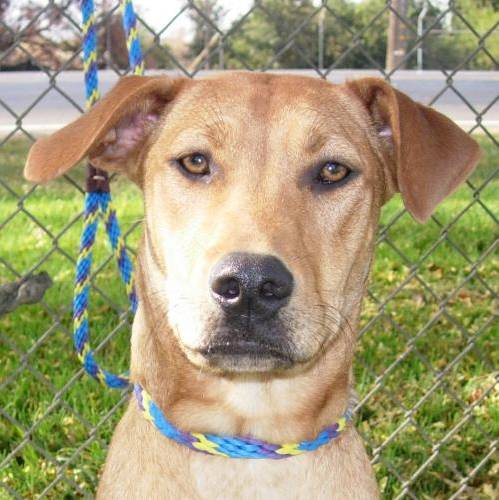

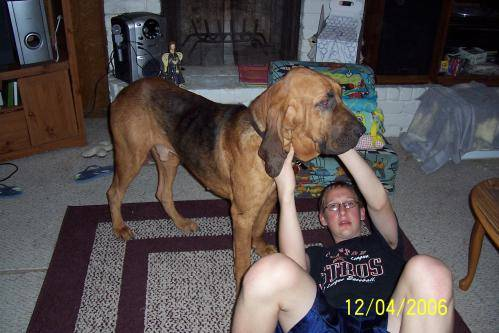

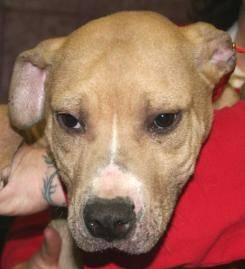

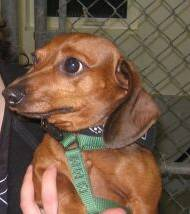

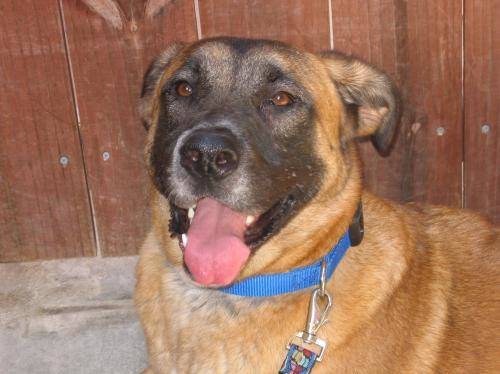

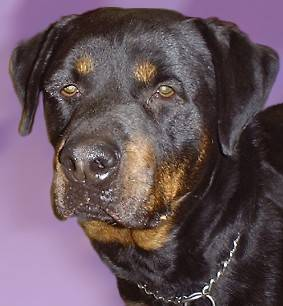

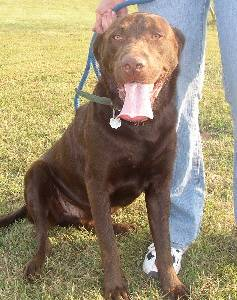

In [247]:
for x in most_correct_dogs:
    display(Image(filename=dsets['valid'].imgs[correct_dogs[x]][0], retina=True))

# Conclusion

What did we do in the end? A simple logistic regression! If the connection is unclear, we'll explain it on a much simpler example in the next course. 

We probably killed a fly with a sledge hammer.

![mouche](https://mlelarge.github.io/dataflowr-web/images/mouche.jpg)

In our case, the sledge hammer is VGG pretrained on Imagenet, a dataset containing a lot of pictures of cats and dogs. Indeed, we saw that without modification the network was able to predict dog and cat breeds. Hence it is not very surprising that the features computed by VGG are very accurate for our classification task. In the end, we need to learn only the parameters of the last linear layer, i.e. 8194 parameters (do not forget the bias $2\times 4096+2$). Indeed, this can be done on CPU without any problem.

Nevertheless, this example is still instructive as it shows all the necessary steps in a deep learning project. Here we did not struggle with the learning process of a deep network, but we did all the preliminary engineering tasks: dowloading a dataset, setting up the environment to use a GPU, preparing the data, computing the features with a pretrained VGG, saving them on your drive so that you can use them for a later experiment... These steps are essential in any deep learning project and a necessary requirement before having fun playing with network architectures and understanding the learning process.

### Calculating preconvoluted features

In [0]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # if you find code like below on internet (or in this course!):
        # Variable is a PyTorch v0.3 recollection...
        # it should still run with newer versions of PyTorch
        #if use_gpu:
        #    inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        #else:
        #    inputs , labels = Variable(inputs),Variable(labels)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [0]:
x_try = model_vgg.features(inputs_try)

In [0]:
?x_try

In [0]:
x_try.data.shape

In [0]:
7*7*512

In [0]:
labels_try

In [0]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

In [0]:
%%time
conv_feat_val,labels_val = preconvfeat(dset_loaders['valid'])

In [0]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]


%mkdir /content/data/dogscats/vgg16


In [0]:
save_array(os.path.join(data_dir,'vgg16','feat_train.bc'),conv_feat_train)
save_array(os.path.join(data_dir,'vgg16','labels_train.bc'),labels_train)
save_array(os.path.join(data_dir,'vgg16','feat_val.bc'),conv_feat_val)
save_array(os.path.join(data_dir,'vgg16','labels_val.bc'),labels_val)

### Uploading Precomputed features

This section will allow you to store the precomputed features on your Google drive for later use.

In [0]:
%cd /content/data/dogscats/
!zip -r vgg16 vgg16/*

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
upload = drive.CreateFile({'title': 'vgg16_drive.zip'})
upload.SetContentFile('vgg16.zip')
upload.Upload()
print('Uploaded file with ID {}'.format(upload.get('id')))

In [0]:
conv_feat_train.shape